### Zielfunktionen und Joint Inversion

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pygimli as pg
from pygimli.physics.ert import VESModelling

Wir betrachten eine Schlumberger-Sondierung mit AB/2-Werten zwischen 3 und 1000m.

In [2]:
ab2 = np.logspace(0.5, 3, 50)
ves = VESModelling(ab2=ab2, mn2=ab2/3)

Wir betrachten ein 3-Schicht-Modell mit einem guten Leiter eingebettet in einen schlecht leitfähigen Halbraum bzw. einem schlechten Leiter im leitfähigen Halbraum.

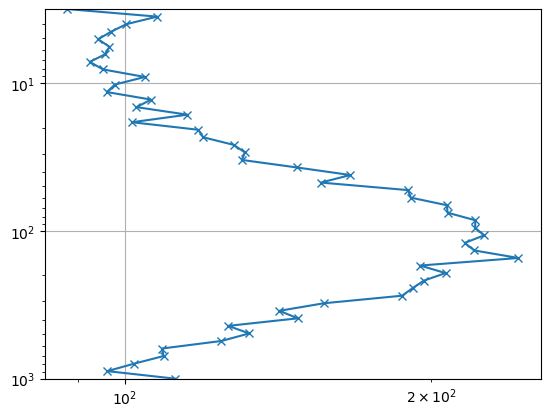

In [3]:
model = [20, 20, 100, 1000, 100]  # d1, d2, r1, r2, r3
data = ves.response(model)
error = 0.05
data *= np.random.randn(len(data)) * error + 1.0
fig, ax = plt.subplots()
ax.loglog(data, ab2, "x-");
ax.set_ylim(max(ab2), min(ab2))
plt.grid()

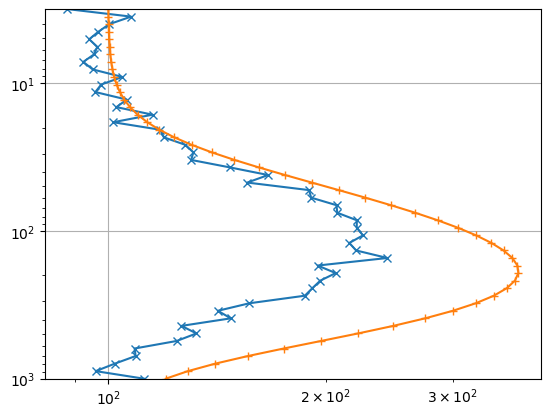

In [4]:
model[1] += 10  # d2
model[3] *= 2  # rho2
response = ves.response(model)
fig, ax = plt.subplots()
ax.loglog(data, ab2, "x-");
ax.loglog(response, ab2, "+-");
ax.set_ylim(max(ab2), min(ab2))
plt.grid()

In [5]:
phiD = lambda x, y, err: np.sum((np.log(x)-np.log(y))**2/err**2)
print("phiD=", phiD(data, response, error))
print("chi2=", phiD(data, response, error)/len(data))

phiD= 2393.17341691631
chi2= 47.8634683383262


Now we consider a series of values for d2 and rho2 and save the objective function for all combinations in a matrix that can then be shown with the function `showPhiD`.

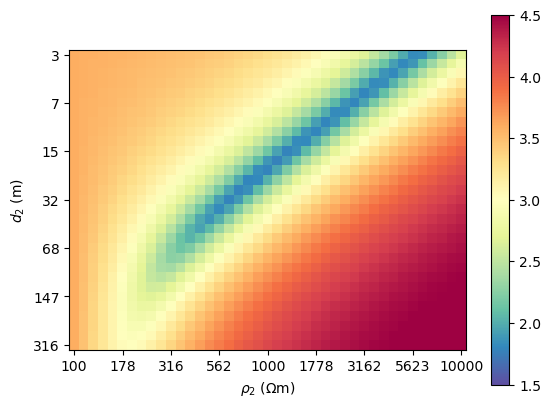

In [6]:
def showPhiD(x, y, mat, xlabel=r"$\rho_2$ ($\Omega$m)", ylabel=r"$d_2$ (m)"):
    fig, ax = plt.subplots()
    im = ax.matshow(np.log10(mat), cmap="Spectral_r", vmin=1.5, vmax=4.5)
    xt = np.arange(0, len(x), 5)
    xtl = ["{:.0f}".format(np.round(xx)) for xx in x[xt]]
    yt = np.arange(0, len(y), 5)
    ytl = ["{:.0f}".format(np.round(yy)) for yy in y[yt]]
    plt.xticks(xt, xtl)
    plt.yticks(yt, ytl)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.xaxis.set_ticks_position("bottom")
    cb = plt.colorbar(im)

thk2 = np.logspace(0.5, 2.5, 31)
res2 = np.logspace(2, 4, 41)
M = np.zeros((len(thk2), len(res2)))
for i, model[1] in enumerate(thk2):
    for j, model[3] in enumerate(res2):
        M[i, j] = phiD(data, ves.response(model), error)

showPhiD(res2, thk2, M);

We now compute the objective function for the case of an electromagnetic frequency sounding using a helicopter-based RESOLVE type bird.

In [7]:
f = np.logspace(2, 5, 10)
fop = pg.core.FDEM1dModelling(3, f, 10., 50)
model = [20, 20, 100, 1000, 100]  # d1, d2, r1, r2, r3
dataEM = fop.response(model)
errorEM = 0.1
dataEM += np.random.randn(len(dataEM)) * errorEM

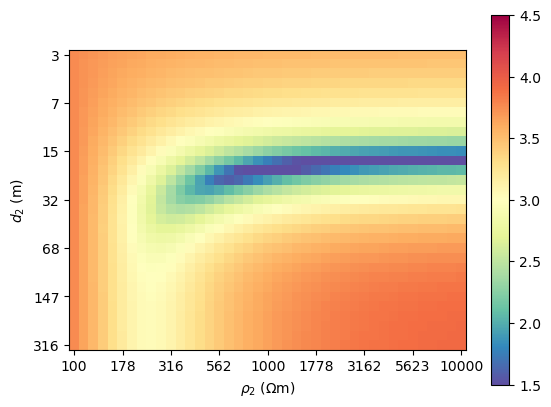

In [8]:
phiD = lambda x, y, err: np.sum((x-y)**2/err**2)
thk2 = np.logspace(0.5, 2.5, 31)
res2 = np.logspace(2, 4, 41)
M2 = np.zeros((len(thk2), len(res2)))
for i, model[1] in enumerate(thk2):
    for j, model[3] in enumerate(res2):
        M2[i, j] = phiD(dataEM, fop.response(model), errorEM)

showPhiD(res2, thk2, M2);

Apparently the thickness is quite well determined, but for the resistivity we can only determine a lower bound.
Now we combine the two measurements (in a joint inversion) by just adding the objective functions.

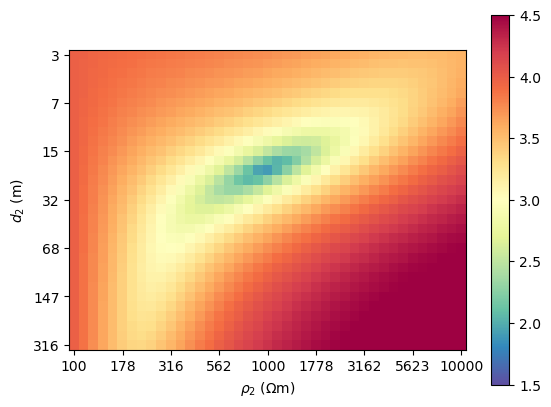

In [9]:
M = M + M2
showPhiD(res2, thk2, M);

As a result, we can much better narrow the values for both resistivity and thickness. Looking at the minimum value of the objective function reveals the optimum model that is very close to the synthetic one.

In [10]:
it, ir = np.nonzero(M == np.min(M))
print(thk2[it], res2[ir])

[19.95262315] [1000.]
